<header style="padding: 4em 0 0em 0">
    <img src="http://brentyi.github.io/filestore/ai4all_logo.svg" style="width: 30em; height: auto; margin: 0;" />
    <h3 style="margin: 1em 0 0 0;">
        <strong>Computer Vision III</strong>
        <span style="color: #777">
        &nbsp;&blacksquare;&nbsp;
        Robotics, Summer 2020</span>
    </h3>
</header>

<hr style="border-top: 0.4em solid #eee;" />

So far, we've explored the foundational ways that we can use Python to store, visualize, and manipulate images.

In this notebook, we'll build on this knowledge to break down the **convolution**, an operation that's driven the last 50+ years of progress in computer vision research.

At the end of this notebook, you'll have:
- Implemented your own convolution function
- Explored its applications: blurring, edge detection, image recognition

We'll be working in grayscale for simplicity, but do think about how you might generalize your code to color images as you progress through the notebook &mdash; this could be useful for your final projects!

<hr style="border-top: 0.4em solid #eee;" />

Start by running the code cell below to load our imports and some helpers for image loading and visualization. These helpers are the same as in the previous notebook:

In [2]:
import numpy as np
from cv_helpers import load_image, visualize_single_channel, rgb2hsl

## 1. Code Study: Image Blur

Before we dive into the convolution operation, let's begin with something slightly more intuitive &mdash; image blurring.

Here's an animation that depicts how we'll approach the image blur problem:

![convolution gif](https://brentyi.github.io/filestore/convolution.gif)

What is this actually depicting?
- The blue grid is the **input image**
- The teal grid is the **output image**
- The shaded portion of the input grid at each step of the animation is a **window**
- The clear squares around the blue grid form the **input padding**: these are treated as input image pixels with intensity values of 0

To blur an image, we iterate over each pixel in the output image and assign it to a value computed by finding the average intensity within an input window. Notice that the window used to compute each output pixel is centered at the corresponding input pixel.

By varying the window size, we can vary the amount of blurring in our output image!

<img src="https://media.giphy.com/media/3kzJvEciJa94SMW3hN/giphy.gif" style="border-radius: 0.5em; width: 15em; height: auto;" alt="blurred pikachu" />

Try running the `pad_image()` and `blur_image()` functions that we've written for you, and see if you can answer the checkoff questions below.

In [3]:
def pad_image(grayscale_image, window_size):
    """Pad the borders of an image with zeros.
    
    Args:
        grayscale_image (np.ndarray): Input image.
        window_size (int): Size of the window we are blurring or convolving over.
            Must be odd.
    
    Returns:
        np.ndarray: Zero-padded image.
    """
    assert len(grayscale_image.shape) == 2, "Image shape must be (rows, cols)"
    assert window_size % 2 == 1, "Window size must be odd!"
    pad_amount = window_size // 2

    # Note: we've explicitly written out the pad operation here for clarity,
    # but we could also use the built-in `np.pad()` function
    padded_image = np.zeros(
        shape=(
            grayscale_image.shape[0] + pad_amount * 2,
            grayscale_image.shape[1] + pad_amount * 2,
        )
    )
    padded_image[
        pad_amount:-pad_amount, pad_amount:-pad_amount
    ] = grayscale_image

    return padded_image


def blur_image(grayscale_image, window_size):
    """Blurs an image using a uniform square window.
    
    Args:
        grayscale_image (np.ndarray): Input image.
        window_size (int): Width/height of window to blur over. Must be odd.
    
    Returns:
        np.ndarray: Blurred image.
    """
    assert window_size % 2 == 1, "Window size must be odd!"

    # Zero-pad our input
    padded_image = pad_image(grayscale_image, window_size)

    # Create the output image -- this should be the same shape as the input
    output_image = np.zeros(shape=grayscale_image.shape)

    # Populate each pixel of the output image
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            window = padded_image[i : i + window_size, j : j + window_size]
            average = np.mean(window)
            output_image[i, j] = average

    # Return the blurred image
    return output_image

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Image Blur Visualization</div>

Using the `visualize_single_channel()` function...

1. Verify that you can display `grayscale_image`.
    - What do you see?
    - Can you explain how we're converting the image to grayscale?
2. Display the output of `pad_image(grayscale_image, window_size=21)`.
    - How did this function change the image?
    - How does the output change as the `window_size` parameter is changed?
3. Display the output of `blur_image(grayscale_image, window_size=21)`.
    - How did this function change the image?
    - How does the output change as the `window_size` parameter is changed?

> *Your response here!*

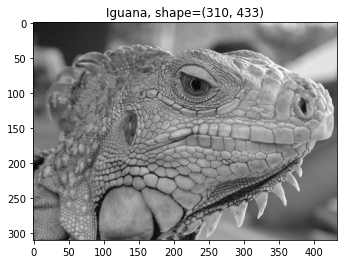

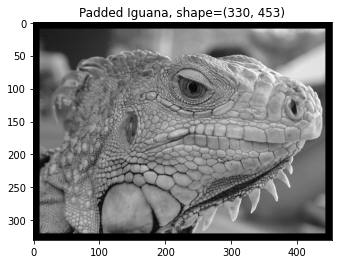

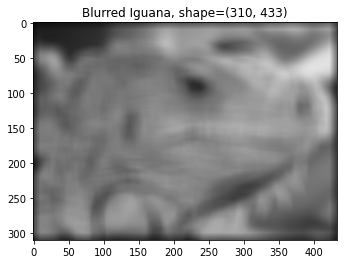

In [4]:
# Load an RGB image of an iguana, then convert it to grayscale
grayscale_image = rgb2hsl(load_image("cv_assets/iguana.png"))[:, :, 2]
assert grayscale_image.shape == (310, 433)

# Visualization code
# ~~START DELETE~~
# Visualize the Iguana
visualize_single_channel("Iguana", grayscale_image)

# Visualize the output of pad_image()
visualize_single_channel("Padded Iguana", pad_image(grayscale_image, 21))

# Visualize the blurred image
visualize_single_channel("Blurred Iguana", blur_image(grayscale_image, 21))
# ~~END DELETE~~

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Code Study: Image Blur</div>

Now that we've visualized the output of our padding and blurring functions, take a look at the code that was used to generate them and see if you can answer these questions:

1. Look up some documentation for `np.mean()` on Google &mdash; what does it do? Why is it useful for blurring?
2. Inside the for loops of `blur_image()`, we define a `window` variable.
    - What does this represent?
    - Why is it defined as `padded_image[i : i + window_size, j : j + window_size]`? Can you explain the indexing? A drawing may help.
3. Notice that we enforce that `window_size` must be an odd integer. Why? (again, a drawing might help!)
4. When we pad our image, we add a border of size `window_size // 2` to each of the 4 edges of the image.
    - How is the `//` division operation different from the `/` operation?
    - Why do we divide by 2?

> *Your response here!*

## 2. Convolutions: Implementation

The simple blur that we implemented above is actually a specific case of a powerful operation called the **convolution**.

Remember our image blur animation from above?

![convolution gif](https://brentyi.github.io/filestore/convolution.gif)

This same GIF can be used to describe a convolution! (in fact: this animation is from an [article](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) that explains convolutions)

In computer vision, the convolution operation is extremely similar to the blurring process that we just explored. It also an involves output image with the same number of rows and columns as the input image, where each output pixel is computed from a window centered at a corresponding input pixel.

Rather than computing each output pixel as the simple average of all values within the window, however, we compute it using a 2D matrix called a **kernel**:

- The kernel has same width and height as the input window
- In a single convolution operation, the same kernel is used to compute every output pixel
- To compute each output pixel, we:
    - Compute the element-wise product between the kernel and the window
    - Assign the output pixel intensity to the sum of all element-wise products

### a) Refresher: Element-wise Multiplication, Summation

Before we get started on implementation, let's revisit two operations that might be useful in NumPy: the element-wise product and `np.sum`.

Run this cell, and make sure you understand the outputs:

In [5]:
# fmt: off
a = np.array([
    [1.0, 2.0, 1.0],
    [1.0, 2.0, 1.0],
    [1.0, 2.0, 1.0],
])
b = np.array([
    [0.0, 2.0, 0.0],
    [1.0, 1.0, 1.0],
    [0.0, 2.0, 0.0],
])
# fmt: on

# Element-wise multiplication
print(a * b)

# Sum
print(np.sum(a))

[[0. 4. 0.]
 [1. 2. 1.]
 [0. 4. 0.]]
12.0


### b) Kernels

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Convolution Kernels</div>

Let's check your understanding of convolutions!

In words, describe what effect each of these kernels will have on an input image. Writing out some examples might help!

$
K_1 = \begin{bmatrix}
    0 & 0 & 0\\
    0 & 1 & 0\\
    0 & 0 & 0\\
\end{bmatrix}\\
\\
K_2 = \begin{bmatrix}
    0 & 0 & 0\\
    0 & 0.5 & 0\\
    0 & 0 & 0\\
\end{bmatrix}\\
\\
\def\val{\frac{1}{9}}
K_3 = \begin{bmatrix}
    \val & \val & \val\\
    \val & \val & \val\\
    \val & \val & \val\\
\end{bmatrix}\\
\\
K_4 = \begin{bmatrix}
    0 & 0 & 0\\
    0 & 0 & 1\\
    0 & 0 & 0\\
\end{bmatrix}\\
\\
K_5 = \begin{bmatrix}
    0 & 0 & 0\\
    -1 & 0 & 1\\
    0 & 0 & 0\\
\end{bmatrix}\\
\\
$

> *Your response here!*

### c) Implementation

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Convolution Implementation</div>

Using `blur_image()` as a reference, implement the `convolve2d()` function.

Validate your implementation on the blur task below, then compare and contrast the two functions.

> *Your response here!*

In [6]:
def convolve2d(grayscale_image, kernel):
    """Applies the convolution operation to an input image.
    
    Args:
        grayscale_image (np.ndarray): Input image.
        kernel (np.ndarray): Square kernel to convolve with.
    
    Returns:
        np.ndarray: Output image. Same shape as input.
    """
    window_size, window_size_alt = kernel.shape
    assert window_size == window_size_alt, "Kernel must be square!"
    assert window_size % 2 == 1, "Window size must be odd!"

    # Implement your convolution here: this should look very similar to
    # `blur_image`, and require two for loops
    # ~~START DELETE~~
    # Zero-pad our input
    padded_image = pad_image(grayscale_image, window_size)

    # Create the output image -- this should be the same shape as the input
    output_image = np.zeros(shape=grayscale_image.shape)

    # Populate each pixel of the output image
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            window = padded_image[i : i + window_size, j : j + window_size]
            output_image[i, j] = np.sum(kernel * window)

    # Return the convolution output
    return output_image
    # ~~END DELETE~~

To validate your implementation, we can compare its output to `blur_image()` when passed a uniform square blurring kernel:

Uniform blur kernel:
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


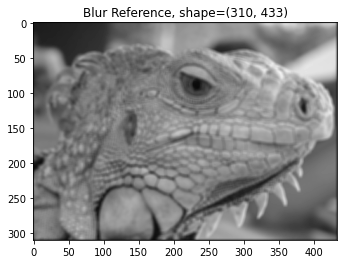

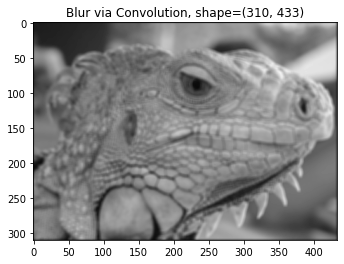

Outputs match!


In [7]:
# Create a kernel that performs a blur over a uniform square window
window_size = 5
uniform_blur_kernel = np.ones((window_size, window_size))
uniform_blur_kernel /= np.sum(uniform_blur_kernel)
print("Uniform blur kernel:")
print(uniform_blur_kernel)

# Visualize a blurred image using `blur_image()`
blurred_image_reference = blur_image(grayscale_image, window_size)
visualize_single_channel("Blur Reference", blurred_image_reference)

# Visualize a blurred image using `convolve2d()`
blurred_image_convolve = convolve2d(grayscale_image, uniform_blur_kernel)
visualize_single_channel("Blur via Convolution", blurred_image_convolve)

# Check that our results actually match!
if np.allclose(blurred_image_reference, blurred_image_convolve):
    print("Outputs match!")
else:
    assert False, "Outputs don't match!"

## 3. Convolutions: Applications

Now that you've implemented your convolution function, let's check out some of the neat things that it can do!

In this section, we'll write very little code &mdash; instead, we'll provide some examples of common convolutional kernels that you can visualize with the convolution function that you've just written.

We'll start off by defining a helper function for "normalization", that is, taking an array with arbitrary values and rescaling them to sit between 0.0 and 1.0.
This will be helpful for visualizing the outputs of some of our convolutions.

In [15]:
def normalize(input_array):
    """Normalize an array. Takes an array with arbitrary values, and rescales
    them to sit between 0.0 and 1.0.
    
    Args:
        input_array (np.ndarray): Array to normalize.

    Returns:
        np.ndarray: Normalized array.
    """
    output_image = input_array - np.min(input_array)
    output_image = output_image / np.max(output_image)
    return output_image

### a) Gaussian Blur

If you've ever edited photos or images in a tool like Photoshop, one operation that you might have seen is the "Gaussian Blur".

This is similar to the simple blur operation that we looked at at the start of this notebook. Rather than weighting all pixels within the window uniformly, however, a Gaussian blur weights each pixel differently based on the distance of the pixel from the center of the window:

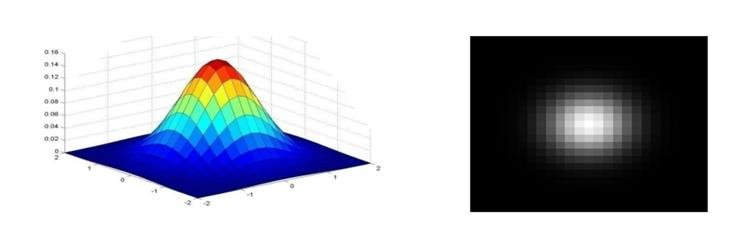

We call this a Gaussian blur because the specific weighting of each pixel is determined by the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution).

We've created a small Gaussian kernel for you below: use your `convolve2d` implementation to blur `grayscale_image`, and run the cell to visualize your results.

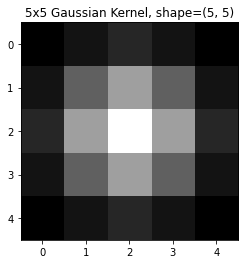

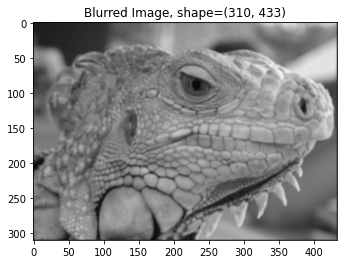

In [16]:
# Create a small Gaussian kernel
gaussian_kernel = (
    np.array(
        [
            [1, 4, 7, 4, 1],
            [4, 16, 26, 16, 4],
            [7, 26, 41, 26, 7],
            [4, 16, 26, 16, 4],
            [1, 4, 7, 4, 1],
        ]
    )
    / 273
)

# fmt: off
blurred_image = convolve2d(grayscale_image, gaussian_kernel)  # ~~DELETE RHS~~
# fmt: on

# Visualize the kernel + blurred image
visualize_single_channel("5x5 Gaussian Kernel", normalize(gaussian_kernel))
visualize_single_channel("Blurred Image", blurred_image)

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Gaussian Blur</div>

Compare and contrast the Gaussian blur with the simple uniform blur we studied in Section 1.

Notice that we "normalize" our Gaussian kernel before visualization: why is this needed?

> *Your response here!*


### b) Edge Detection
#### i. Vertical & Horizontal Edge Detectors

Next, let's look at edge detection. Can we write code that examines an input image and detects lines within it?

To do this, we break down our edge detection problem into two parts: detecting vertical edges and horizontal edges.

Take a look at these kernels, typically called "Sobel filters":

$
K_\text{vertical edges} = \begin{bmatrix}
    -1 & 0 & 1\\
    -2 & 0 & 2\\
    -1 & 0 & 1\\
\end{bmatrix}
$

$
K_\text{horizontal edges} = \begin{bmatrix}
    -1 & -2 & -1\\
    0 & 0 & 0\\
    1 & 2 & 1\\
\end{bmatrix}
$

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Sobel Filters</div>

Describe in words what applying each kernel does. How might they help us with edge detection?

When you're done, write out these kernels using NumPy and run the visualization code below!

> *Your response here!*

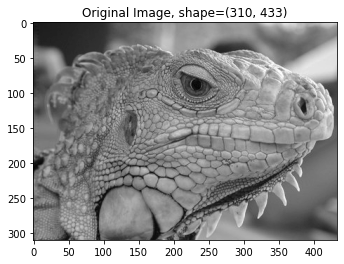

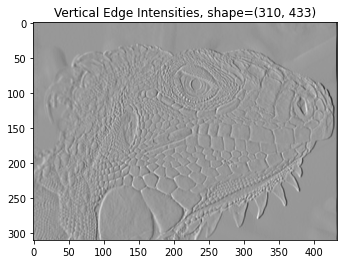

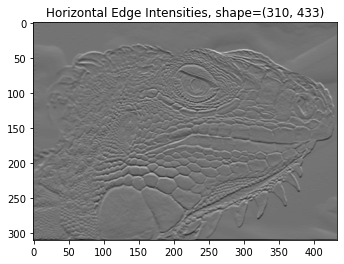

In [19]:
vertical_edge_kernel = None
horizontal_edge_kernel = None

# Define vertical_edge_kernel and horizontal_edge_kernel as 2D NumPy arrays
# ~~START DELETE~~
# fmt:off
vertical_edge_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
horizontal_edge_kernel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1],
])
# fmt:on
# ~~END DELETE~~

# Validate kernels
assert vertical_edge_kernel.shape == (3, 3)
assert horizontal_edge_kernel.shape == (3, 3)

# Detect edges using our convolve2d function
vertical_edges = convolve2d(grayscale_image, vertical_edge_kernel)
horizontal_edges = convolve2d(grayscale_image, horizontal_edge_kernel)

# Visualize original image, as well as edge detections
visualize_single_channel("Original Image", grayscale_image)
visualize_single_channel(
    "Vertical Edge Intensities", normalize(vertical_edges)
)
visualize_single_channel(
    "Horizontal Edge Intensities", normalize(horizontal_edges)
)

#### ii. Edge Detection & Trigonometry

With our Sobel filters, we've broken down our edges into two components: a vertical one and a horizontal one.

While relatively straightforward to compute, these two numbers aren't always the easiest to interpret. Instead, computer vision algorithms often use an alternate way of describing edges: by their **magnitude** and **orientations**.

To compute these, we can treat the horizontal and vertical edge components as legs of a(n imaginary) right triangle. The vertical edge value is $y$, and the horizontal one is $x$:

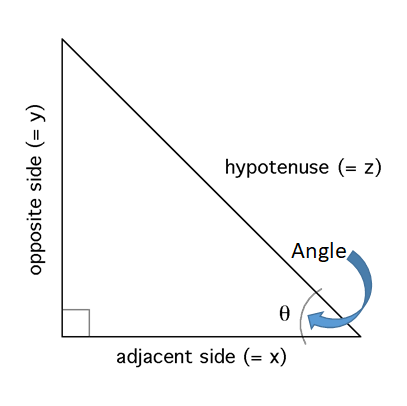

In a right triangle:
- The hypotenuse of the triangle can be computed as $\sqrt{x^2 + y^2}$
    - For us, this is the **magnitude** of the edge
- $\tan(\theta) = \frac{y}{x} \implies$ given $x$ and $y$, we can compute the angle using an inverse tangent (arctan)
    - For us, this is the **orientation** of the edge

Note that, for *each pixel*:
- We have one horizontal edge value and one vertical edge value
- We want to compute one magnitude and one orientation

We've written out the magnitude computation for you below -- try writing the orientation one! For computing the inverse tangent, look up the documentation for `np.arctan2()`.

In [20]:
# Compute magnitudes
# Note that this happens element-wise!
edge_magnitudes = np.sqrt(vertical_edges ** 2 + horizontal_edges ** 2)

# Compute orientations
# For this, you should use `np.arctan2()`
# fmt: off
edge_orientations = np.arctan2(vertical_edges, horizontal_edges)  # ~~DELETE RHS~~
# fmt: on

Let's try visualizing these values!

Notice that the **hue** component of HSL (hue saturation lightness) is circular; on a 0-1 scale, a hue value of `0.0` is the same as `1.0` (both are red):

<img src="https://brentyi.github.io/filestore/hsl.png" style="width: 20em; height: auto;" />

This makes it an intuitive way to visualize edge orientations, where an orientation of $-\pi$ radians (-180 degrees) is the same as an orientation of $\pi$ radians (180 degrees):

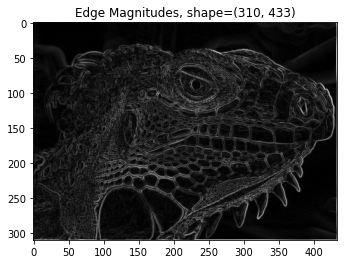

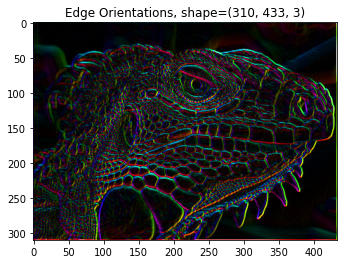

In [21]:
# Visualize edge magnitudes
visualize_single_channel("Edge Magnitudes", normalize(edge_magnitudes))

# Visualize edge orientations -- using HSL!
from cv_helpers import hsl2rgb, visualize_rgb

viz_hsl = np.zeros(grayscale_image.shape + (3,))
viz_hsl[:, :, 0] = (edge_orientations + np.pi) / (2 * np.pi)
viz_hsl[:, :, 1] = 1.0
viz_hsl[:, :, 2] = normalize(edge_magnitudes)

visualize_rgb("Edge Orientations", hsl2rgb(viz_hsl))

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Edge Detection</div>

Show off your edge orientation visualization! It should look something like this:

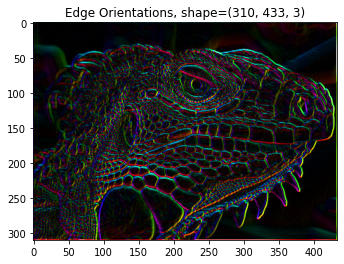

Cool, huh?

For edge orientations, why do we use the `np.arctan2()` function (which takes 2 arguments) over the simpler `np.arctan()` function (which takes 1 argument)? [Wikipedia](https://en.wikipedia.org/wiki/Atan2) might be helpful here.

How was the edge orientation visualization generated? Explain the values that we used for the H, S, and L channels.

> *Your response here!*

### c) Object Localization

Last but certainly not least, we can use the convolution function that you wrote for general **object localization**.

We'll specifically demonstrate this with a game of [Where's Waldo?](https://en.wikipedia.org/wiki/Where%27s_Wally%3F).

Given a "patch" depicting Waldo:

![where's waldo](cv_assets/waldo.jpg)

And an image of a larger scene:

![where's waldo](cv_assets/wheres_waldo.jpg)

...we can use a convolution to find the exact position of Waldo within the scene!

Let's do this by first loading up the images of Waldo:

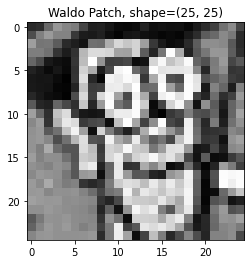

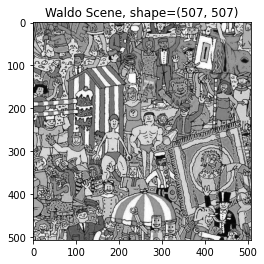

In [22]:
patch_image = rgb2hsl(load_image("cv_assets/waldo.jpg"))[:, :, 2]
visualize_single_channel("Waldo Patch", patch_image)

scene_image = rgb2hsl(load_image("cv_assets/wheres_waldo.jpg"))[:, :, 2]
visualize_single_channel("Waldo Scene", scene_image)

To find Waldo, we can zero-mean our Waldo patch and use it as a convolutional kernel!  This produces a grid of similarity scores. To figure out where Waldo is, we find the location with the highest score.

We've defined the kernel for you already &mdash; use your convolution function to compute a grid of similarity scores, and run this cell to find Waldo:

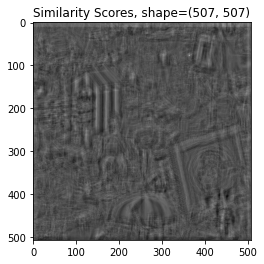

Found Waldo at: (77, 363)


In [13]:
# Define our convolutional kernel: this is simply the image patch with the mean subtracted
patch_kernel = patch_image - np.mean(patch_image)

# Convolve the kernel over our input scene
similarity_scores = convolve2d(scene_image, patch_kernel)  # ~~DELETE RHS~~
visualize_single_channel("Similarity Scores", normalize(similarity_scores))

# Print the location with the highest similarity score
# If you're interested in how this works, look up the documentation for
# `np.argmax` and `np.unravel_index`!
waldo_location = np.unravel_index(
    np.argmax(similarity_scores), similarity_scores.shape
)
print("Found Waldo at:", waldo_location)

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Object Localization</div>

Where's Waldo? <span style="color: #aaa">(in image coordinates)</a>

> *Your response here!*

And that's it for this notebook! We hope you've built some intuition for the convolution operator, as well as a bit of appreciation for just how widely it's used in CV. The applications we've studied in this notebook establish the foundations for the entire field of modern computer vision.

Next up: we'll be looking at data-driven approaches to computer vision in our machine learning unit!